In [223]:
from __future__ import division
import scipy.io
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as distance

from multiprocessing import Pool
np.set_printoptions(precision=2, suppress=True)

# Data Processing

In [178]:
d = scipy.io.loadmat('spamData.mat')
ytest = d['ytest'].flatten()
ytrain = d['ytrain'].flatten()
xtest = d['Xtest']
xtrain = d['Xtrain']

In [3]:
def binarize(array):
    """array: list of emails, each 57 features long"""
    return np.array([x>0 for x in array]).astype('uint8')
xtrainBin = binarize(xtrain)
xtestBin = binarize(xtest)

In [4]:
#z-normalise features
def znorm1D(array1D):
    m = np.mean(array1D)
    s = np.std(array1D)
    return np.array((array1D-m)/s)
def znorm2D(array2D):
    """znorm along columns of 2D array"""
    znormed_columns = np.array([znorm1D(c) for c in array2D.T]) # each column in array2D is a row (called c) in array2D.T
    return znormed_columns.T
xtrainZ = znorm2D(xtrain)
xtestZ = znorm2D(xtest)

In [5]:
#log-transform features
def log2D(array):
    """array: list of emails, each 57 features long"""
    return np.array([np.log(x+0.1) for x in array]).astype('uint8') #x is a 57 element array
xtrainLog = log2D(xtrain)
xtestLog = log2D(xtest)

In [210]:
Kays = np.insert(np.arange(15,105,5),0,np.arange(1,11,1))
print Kays

[  1   2   3   4   5   6   7   8   9  10  15  20  25  30  35  40  45  50
  55  60  65  70  75  80  85  90  95 100]


# Binarised

In [6]:
def HammingDistance(email1,email2):
    """number of features that are different between two binarised lists"""
    return np.sum(np.logical_xor(email1,email2))

In [141]:
def HD(x1_array2D,x2_array2D): 
    """
    return Hamming Distances between mails x1 in x1_array2D and x2 in x2_array2D,
    not the most efficient...
    """
    return np.array([[HammingDistance(x1_array2D[idx1],x2_array2D[idx2]) for idx2 in np.arange(len(x2_array2D))] for idx1 in np.arange(len(x1_array2D))])

In [115]:
HD_train = HD(xtrainBin,xtrainBin) # compute all distances, go have some coffee...

In [124]:
np.savetxt('HammingDistances_training.dat',np.array(HD_train))

In [142]:
HD_test = HD(xtestBin,xtrainBin) # compute all distances, go have some coffee...

In [143]:
np.savetxt('HammingDistances_testing.dat',np.array(HD_test))

In [135]:
HD_train[2]

array([25, 31,  0, ..., 13, 26, 33])

In [137]:
a = [0,1,2,3,4]
a[0:4]

[0, 1, 2, 3]

In [153]:
def KnnClassify_OneMail(distances_array1D, k,
                        y_array1D=ytrain):
    """
    classifies a single mail given a distance array specifying its distances from all other training mails
    as the distance array includes the distance from itself (0 units), 
    we find the k-nearest neighbours from the second smallest distance onwards.
    """
    ClosestEmails_Indices = np.argsort(distances_array1D)[1:k+1]
    Counts1 = np.sum(y_array1D[ClosestEmails_Indices]==1)
    Counts0 = np.sum(y_array1D[ClosestEmails_Indices]==0)
    return Counts1>Counts0

In [155]:
def KnnClassify_AllMails(distances_array2D,k):
    return np.array(
        [KnnClassify_OneMail(distances_array1D,k) for distances_array1D in distances_array2D]
    )

In [170]:
def error_rate(distances_array2D,y_array1D,k):
    """
    uses KNN to classify mails whose distance to the training mails is described by distances_array2D,
    y_array1D: class labels for comparison with classifier results
    """
    N = len(y_array1D)
    results = KnnClassify_AllMails(distances_array2D,k)
    return np.sum(np.logical_xor(results,y_array1D))/N*100

In [214]:
error_rate(HD_train,ytrain,1)

10.70146818923328

In [191]:
Bin_ErrorRates_Testing = map(lambda k: error_rate(HD_test,ytest,k),Kays) 

In [244]:
# np.savetxt('Bin_ErrorRates_Testing.dat',Bin_ErrorRates_Testing)
Bin_ErrorRates_Testing = np.loadtxt('Bin_ErrorRates_Testing.dat')

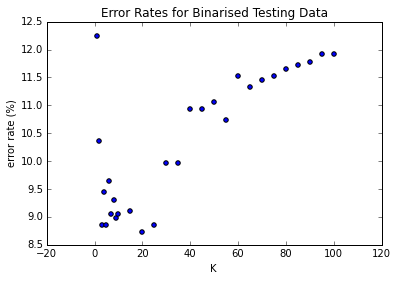

In [245]:
%matplotlib inline
plt.figure()
plt.title('Error Rates for Binarised Testing Data')
plt.scatter(Kays,Bin_ErrorRates_Testing)
plt.xlabel('K')
plt.ylabel('error rate (%)')
plt.show()

In [198]:
Bin_ErrorRates_Training = map(lambda k: error_rate(HD_train,ytrain,k),Kays) 

In [246]:
# np.savetxt('Bin_ErrorRates_Training.dat',Bin_ErrorRates_Training)
Bin_ErrorRates_Training = np.loadtxt('Bin_ErrorRates_Training.dat')

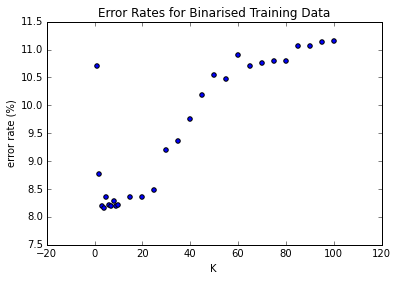

In [247]:
%matplotlib inline
plt.figure()
plt.title('Error Rates for Binarised Training Data')
plt.scatter(Kays,Bin_ErrorRates_Training)
plt.xlabel('K')
plt.ylabel('error rate (%)')
plt.show()

## Comments on error rates varying with K
There seems to be an optimal number of neighbours (approximately 3-20) where the error rates are the lowest.
If K < 3 then there might be too few neighbours to make an accurate comparison.
If K > 20 then neighbours that are further away from the mail to be categorised, which might have little correlation to the mail, are taken into account, and the error rates start to increase.

The training error is not 0 when it looks for 1 nearest neighbour due to too little data - it should approach zero as more training data is available.

In [261]:
# Error rates for K = 1,10,100
print np.array([Bin_ErrorRates_Training[Kays==i] for i in [1,10,100]])
print np.array([Bin_ErrorRates_Testing[Kays==i] for i in [1,10,100]])

[[ 10.7 ]
 [  8.22]
 [ 11.16]]
[[ 12.24]
 [  9.05]
 [ 11.91]]


In [221]:
# Define distance functions for continuous features

In [219]:
def EuclideanDistance(u,v):
    """uses scipy package to calculate euclidean distance"""
    return distance.euclidean(u,v)

In [220]:
def ED(x1_array2D,x2_array2D):
    """
    return Euclidean Distances between mails x1 in x1_array2D and x2 in x2_array2D,
    not the most efficient...
    """
    return np.array([[EuclideanDistance(x1_array2D[idx1],x2_array2D[idx2]) for idx2 in np.arange(len(x2_array2D))] for idx1 in np.arange(len(x1_array2D))])

# Z-normed

In [224]:
ED_TrainingZ = ED(xtrainZ,xtrainZ)

In [225]:
np.savetxt('EuclideanDistances_TrainingZ.dat',np.array(ED_TrainingZ))

In [226]:
ED_TestingZ = ED(xtestZ,xtrainZ)

In [227]:
np.savetxt('EuclideanDistances_TestingZ.dat',np.array(ED_TestingZ))

In [229]:
Z_ErrorRates_Testing = map(lambda k: error_rate(ED_TestingZ,ytest,k),Kays) 

In [230]:
Z_ErrorRates_Training = map(lambda k: error_rate(ED_TrainingZ,ytrain,k),Kays) 

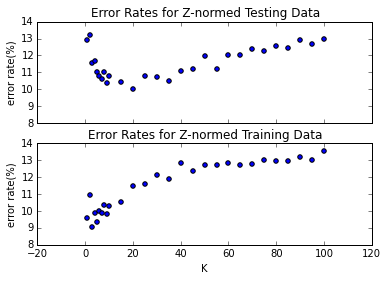

In [243]:
f, [ax0,ax1] = plt.subplots(2, sharex=True, sharey=True)
ax0.set_title('Error Rates for Z-normed Testing Data')
ax1.set_title('Error Rates for Z-normed Training Data')
ax0.scatter(Kays,Z_ErrorRates_Testing)
ax1.scatter(Kays,Z_ErrorRates_Training)
ax1.set_xlabel('K')
ax0.set_ylabel('error rate(%)')
ax1.set_ylabel('error rate(%)')

In [267]:
# Error rates for K = 1,10,100
print [np.array(Z_ErrorRates_Training)[Kays==i] for i in [1,10,100]]
print [np.array(Z_ErrorRates_Testing)[Kays==i] for i in [1,10,100]]

[array([ 9.59]), array([ 10.31]), array([ 13.54])]
[array([ 12.89]), array([ 10.81]), array([ 12.96])]


## Comments on error rates varying with K
The error rates are lower for the training set (compared to the testing set) for lower values of K.
This could indicate overfitting for low K values.

# Log-transformed

In [248]:
ED_TrainingLog = ED(xtrainLog,xtrainLog)

In [249]:
np.savetxt('EuclideanDistances_TrainingLog.dat',np.array(ED_TrainingLog))

In [250]:
ED_TestingLog = ED(xtestLog,xtrainLog)

In [251]:
np.savetxt('EuclideanDistances_TestingLog.dat',np.array(ED_TestingLog))

In [252]:
Log_ErrorRates_Testing = map(lambda k: error_rate(ED_TestingLog,ytest,k),Kays) 

In [253]:
Log_ErrorRates_Training = map(lambda k: error_rate(ED_TrainingLog,ytrain,k),Kays) 

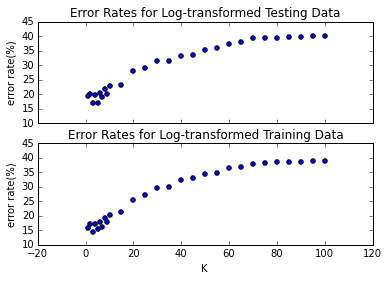

In [254]:
g, [ax0,ax1] = plt.subplots(2, sharex=True, sharey=True)
ax0.set_title('Error Rates for Log-transformed Testing Data')
ax1.set_title('Error Rates for Log-transformed Training Data')
ax0.scatter(Kays,Log_ErrorRates_Testing)
ax1.scatter(Kays,Log_ErrorRates_Training)
ax1.set_xlabel('K')
ax0.set_ylabel('error rate(%)')
ax1.set_ylabel('error rate(%)')

In [268]:
# Error rates for K = 1,10,100
print [np.array(Log_ErrorRates_Training)[Kays==i] for i in [1,10,100]]
print [np.array(Log_ErrorRates_Testing)[Kays==i] for i in [1,10,100]]

[array([ 15.79]), array([ 20.33]), array([ 38.89])]
[array([ 19.27]), array([ 22.66]), array([ 39.97])]


# Comments on error rates for different preprocessing strategies
Binarised data have generally lower error rates compared to other strategies.
This is in contrast to the observations made for logistic regression.